# FIT5202 2025 S2 Assignment 1 : Analysing Australian Property Market Data

## Table of Contents
* [Part 1 : Working with RDD](#part-1)  
    - [1.1 Data Preparation and Loading](#1.1)  
    - [1.2 Data Partitioning in RDD](#1.2)  
    - [1.3 Query/Analysis](#1.3)  
* [Part 2 : Working with DataFrames](#2-dataframes)  
    - [2.1 Data Preparation and Loading](#2-dataframes)  
    - [2.2 Query/Analysis](#2.2)  
* [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)  

Note: Feel free to add Code/Markdown cells as you need.

# Part 1 : Working with RDDs (30%) <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries. 

1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
1.	Write the code to create a SparkContext object using SparkSession. To create a SparkSession, you first need to build a SparkConf object that contains information about your application. Use Melbourne time as the session timezone. Give your application an appropriate name and run Spark locally with 4 cores on your machine.

In [335]:
# Import SparkConf class into program
from pyspark import SparkConf

# Run Spark in local mode with as 4 cores 
master = "local[4]"
# Set app name
app_name = "Assignment 1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = (
    SparkSession.builder
    .config(conf=spark_conf)
    .config("spark.sql.session.timeZone", "Australia/Melbourne")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [336]:
import re
from itertools import islice
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.rdd import RDD
import os
from datetime import datetime
import matplotlib.pyplot as plt
import statistics
from pyspark.sql import functions as F, Window as W
import pandas as pd
import seaborn as sns
import time
from datetime import date

%matplotlib notebook

1.1.2 Load the CSV and JSON files into multiple RDDs. 

In [337]:
# CSV file
rdd_nsw_property_price = sc.textFile('dataset/nsw_property_price.csv')

# JSON file
rdd_council = sc.wholeTextFiles('dataset/council.json')
rdd_property_purpose = sc.wholeTextFiles('dataset/property_purpose.json')
rdd_zoning = sc.wholeTextFiles('dataset/zoning.json')

In [338]:
rdd_council.take(5)

[('file:/home/student/assignmengt01/dataset/council.json',
  '{\n"council_id,council_name\\n": [\n\t{\n\t\t"council_id" : 1,\n\t\t"council_name" : "003"\n\t},\n\t{\n\t\t"council_id" : 2,\n\t\t"council_name" : "011"\n\t},\n\t{\n\t\t"council_id" : 3,\n\t\t"council_name" : "013"\n\t},\n\t{\n\t\t"council_id" : 4,\n\t\t"council_name" : "014"\n\t},\n\t{\n\t\t"council_id" : 5,\n\t\t"council_name" : "020"\n\t},\n\t{\n\t\t"council_id" : 6,\n\t\t"council_name" : "021"\n\t},\n\t{\n\t\t"council_id" : 7,\n\t\t"council_name" : "022"\n\t},\n\t{\n\t\t"council_id" : 8,\n\t\t"council_name" : "024"\n\t},\n\t{\n\t\t"council_id" : 9,\n\t\t"council_name" : "026"\n\t},\n\t{\n\t\t"council_id" : 10,\n\t\t"council_name" : "028"\n\t},\n\t{\n\t\t"council_id" : 11,\n\t\t"council_name" : "029"\n\t},\n\t{\n\t\t"council_id" : 12,\n\t\t"council_name" : "031"\n\t},\n\t{\n\t\t"council_id" : 13,\n\t\t"council_name" : "034"\n\t},\n\t{\n\t\t"council_id" : 14,\n\t\t"council_name" : "035"\n\t},\n\t{\n\t\t"council_id" : 15,\n

1.1.3 For each RDD, remove the header rows and display the total count and the first 8 records.


In [339]:
# Function to manage JSON file
def json_values_rdd(rdd):
    
    """ Removing header and exclude the symbols that 
    are not related to main content of json data 
    and store in list """
    
    # Select only value of RDD
    txt = rdd.values()

    def remove_commas(s):
        # Exclude , before } or ] to prevent error
        return re.sub(r',(?=\s*[}\]])', '', s)

    def to_rows(text):
        
        # Convert JSON string and convert to be list
        
        try:
            # Convert from string in JSON pattern to Python object
            # In case cannot parse, return the empty list
            obj = json.loads(remove_commas(text))
        except Exception:
            return []
        
        # Find first value and collect it in lists
        lists = []
        for v in obj.values():
            lists.append(v)
                
        # Store values at index 0 of 'list' to store in 'arr'
        arr = lists[0] if lists else []
        
        # Store values at index 0 of 'arr' to store in 'first'
        first = arr[0]

        # If first item is a dict: use its keys as columns
        if isinstance(first, dict):
            # use the first record as keys value
            cols = list(first.keys())  
            rows = []
            # Loop to store row values in column order  
            for rec in arr:            
                row = [] 
                # Returns None if the key is missing
                for c in cols:
                    row.append(rec.get(c))  
                rows.append(row)
            return rows

    # Apply to_rows to each item in 'txt' and flatten all returned rows
    return txt.flatMap(to_rows)

In [340]:
# Apply json_values_rdd() function with RDD file
rdd_council_clean = json_values_rdd(rdd_council)
rdd_property_purpose_clean = json_values_rdd(rdd_property_purpose)
rdd_zoning_clean = json_values_rdd(rdd_zoning)

In [341]:
print(rdd_council_clean.count(), "counts")
print(rdd_council_clean.take(8))

220 counts
[[1, '003'], [2, '011'], [3, '013'], [4, '014'], [5, '020'], [6, '021'], [7, '022'], [8, '024']]


In [342]:
print(rdd_property_purpose_clean.count(), "counts")
print(rdd_property_purpose_clean.take(8))

865 counts
[[1, ''], [16, '0FFICE'], [29, '10 FLATS'], [31, '10 UNITS'], [115, '2'], [159, '2 CAR SPACES'], [167, '2 FLATS'], [190, '2 SHEDS']]


In [343]:
print(rdd_zoning_clean.count(), "counts") 
print(rdd_zoning_clean.take(8))

71 counts
[[1, ''], [2, 'A'], [3, 'AGB'], [4, 'B'], [5, 'B1'], [6, 'B2'], [7, 'B3'], [8, 'B4']]


In [344]:
# Remove header and parsencsv file

# Store header line
header_line = rdd_nsw_property_price.first()

# Keep regex for spliting commas that are NOT inside double quotes
split_csv = re.compile(r',(?=(?:[^"]*"[^"]*")*[^"]*$)')

# Define function to remove the noise to keep the real contents
def parse_csv_re(line: str):
    
    # Remove comma before closing bracket
    # Remove \r\n at the end of line
    parts = split_csv.split(line.rstrip('\r\n'))
    
    output = []
    
    for s in parts:
        # Trim spaces around a field
        s = s.strip()
        # If length of field is more than or equal 2, and contain open and cloe quote 
        if len(s) >= 2 and s[0] == '"' and s[-1] == '"':
            # Remove outer quotes and turn "" into "
            s = s[1:-1].replace('""','"')
        # Append field to output
        output.append(s)
        
    return output

# Parse the header into a list of column names
csv_cols = parse_csv_re(header_line)

# Remove header of first partition 
body_lines = rdd_nsw_property_price.mapPartitionsWithIndex(lambda i,it: islice(it,1,None) if i==0 else it)

# parse each data line into columns
rdd_nsw_property_price_clean = (body_lines
            .map(parse_csv_re))

print('rows =', rdd_nsw_property_price_clean.count())
print(rdd_nsw_property_price_clean.take(8))

rows = 4854814
[['4270509', '1400000.00', '8 C NYARI RD, KENTHURST', '2156', 'house', '', '', '2.044', 'H', '2023-12-14', '2024-02-14', 'V', '2/1229857', '142', '200', '9922', '53'], ['4329326', '1105000.00', '82 CAMARERO ST, BOX HILL', '2765', 'house', '', '', '300.2', 'M', '2024-01-12', '2024-02-09', 'R', '1119/1256791', '143', '200', '7071', '41'], ['1864112', '55000.00', '321 AUBURN ST, MOREE', '2400', 'house', '', '', '847.3', 'M', '2023-09-15', '2024-01-29', 'R', '17/36061', '192', '168', '7071', '40'], ['1869899', '680000.00', '207 GWYDIRFIELD RD, MOREE', '2400', 'house', '', 'SPRINGVALE', '2.023', 'H', '2024-01-19', '2024-02-09', 'R', '6/251911', '193', '168', '7071', '48'], ['1867775', '220000.00', '90 MERRIWA ST, BOGGABILLA', '2409', 'house', '', '', '2023.0', 'M', '2023-12-08', '2024-02-09', 'R', '1/1/758127', '194', '168', '7071', '52'], ['2738374', '690000.00', '10 PETOSTRUM PL, PORT MACQUARIE', '2444', 'house', '', '', '672.8', 'M', '2023-12-14', '2024-02-14', 'R', '94/81

In [345]:
# store header in price_idx
price_idx = {name: i for i, name in enumerate(csv_cols)} 

C_ID = price_idx['council_id']
P_ID = price_idx['purpose_id']
Z_ID= price_idx['zone_id']
ISO_CON_DATE = price_idx['iso_contract_date']
ISO_SET_DATE = price_idx['iso_settlement_date']

1.1.4 Drop records with invalid information: purpose_id or council_id is null, empty, or 0.

In [346]:
# Define function to drop records containing null value, empty value, and 0
def drop_null_0_value(value):
    # make value a string, trim whitespaces, lowercase
    # If value is None, becomes ''
    string = '' if value is None else str(value).strip().lower()
    return string not in ('', '0', 'null', 'none', 'na', 'nan')

In [347]:
# Remove null, empty, and 0 from RDD of 'council'
rdd_council_clean_02 = (
    rdd_council_clean
        .filter(lambda r: drop_null_0_value(r[0]))
)

# Remove null, empty, and 0 from RDD of 'property_purpose'
rdd_property_purpose_clean_02 = (
    rdd_property_purpose_clean
      .filter(lambda r: drop_null_0_value(r[0]))                                    
)

# Remove null, empty, and 0 from RDD of 'nsw_property_price'
rdd_nsw_property_price_clean_02 = (
    rdd_nsw_property_price_clean
      .filter(lambda r: drop_null_0_value(r[P_ID]) and drop_null_0_value(r[C_ID]))
      .cache()
)

In [348]:
print('council =', rdd_council_clean_02.count()); print(rdd_council_clean_02.take(3))
print('property_purpose =', rdd_property_purpose_clean_02.count()); print(rdd_property_purpose_clean_02.take(3))
print('nsw_property_price =', rdd_nsw_property_price_clean_02.count()); print(rdd_nsw_property_price_clean_02.take(3))

council = 220
[[1, '003'], [2, '011'], [3, '013']]
property_purpose = 865
[[1, ''], [16, '0FFICE'], [29, '10 FLATS']]
nsw_property_price = 4836784
[['4270509', '1400000.00', '8 C NYARI RD, KENTHURST', '2156', 'house', '', '', '2.044', 'H', '2023-12-14', '2024-02-14', 'V', '2/1229857', '142', '200', '9922', '53'], ['4329326', '1105000.00', '82 CAMARERO ST, BOX HILL', '2765', 'house', '', '', '300.2', 'M', '2024-01-12', '2024-02-09', 'R', '1119/1256791', '143', '200', '7071', '41'], ['1864112', '55000.00', '321 AUBURN ST, MOREE', '2400', 'house', '', '', '847.3', 'M', '2023-09-15', '2024-01-29', 'R', '17/36061', '192', '168', '7071', '40']]


### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, using Spark’s default partitioning, print out the total number of partitions and the number of records in each partition

In [349]:
def print_partitions(rdd):
    
    ''' counts rows per partition of RDD '''
    
    # map the rows of the RDD file to count the rows
    counts = (
    # Run once per partition, with its index
    # to count how many rows are in the partition
    rdd.mapPartitionsWithIndex(
            lambda idx, rows: [(idx, sum(1 for row in rows))]
        )
        # Sort by partition index
        .sortByKey()
        # Bring the small result back to the driver to print it
        .collect()
    )
    
    # For loop to print out the results
    for i, c in counts:
        print(f'partition {i}: {c} records')
        

In [350]:
# "council"
print(f"Number of council's partition: {rdd_council_clean_02.getNumPartitions()}")
print_partitions(rdd_council_clean_02)

Number of council's partition: 1
partition 0: 220 records


In [351]:
# "property_purpose"
print(f"Number of property_purpose's partition: {rdd_property_purpose_clean_02.getNumPartitions()}")
print_partitions(rdd_property_purpose_clean_02)

Number of property_purpose's partition: 1
partition 0: 865 records


In [352]:
# "nsw_property_price"
print(f"Number of nsw_property_price's partition: {rdd_nsw_property_price_clean_02.getNumPartitions()}")
print_partitions(rdd_nsw_property_price_clean_02)

Number of nsw_property_price's partition: 19
partition 0: 257607 records
partition 1: 256570 records
partition 2: 254864 records
partition 3: 255394 records
partition 4: 255727 records
partition 5: 258108 records
partition 6: 258790 records
partition 7: 257272 records
partition 8: 255254 records
partition 9: 254686 records
partition 10: 254416 records
partition 11: 253181 records
partition 12: 253382 records
partition 13: 255223 records
partition 14: 254220 records
partition 15: 257933 records
partition 16: 257370 records
partition 17: 255693 records
partition 18: 231094 records


In [353]:
# "zoning"
print(f"Number of nsw_property_price's partition: {rdd_zoning_clean.getNumPartitions()}")
print_partitions(rdd_zoning_clean)

Number of nsw_property_price's partition: 1
partition 0: 71 records


1.2.2 Answer the following questions:   
a) How many partitions do the above RDDs have?  
b) How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it is partitioned in this number?   
c) Assuming we are querying the dataset based on <strong> Property Price</strong>, can you think of a better strategy for partitioning the data based on your available hardware resources?  

Answer for a: 
RDDs of council, property purpose, zoning have 1 partition.
However, nsw property price has 19 partitions.

Answer for b: <br>
When we do not explicitly specify any partitioning strategy, Spark will use the Hadoop InputFormat to split to file to input splits and give 1 split = 1 partition. The size of split is based on the block size of the file reading system. In this case, files were read by Local FileSystem, the default size of block approximately 32 MB.Thus, the number of partition is approximately size of file divided by block-size. <br>
    - nsw_property_price.csv using .textFile() to read it as its size is approximately 607 MB. Therefore, the number of partition is approximately 607/32 = 19 partitions.<br>
    - The others is the small file size than block size. Therefore, whole file can be in 1 partition. 

In [354]:
 # Got size (bytes) of each file
council_sz = os.path.getsize("dataset/council.json")
property_purpose_sz = os.path.getsize("dataset/property_purpose.json")
zoning_sz = os.path.getsize("dataset/zoning.json")
nsw_property_price_sz = os.path.getsize("dataset/nsw_property_price.csv")

# File size of council
print("'council' file size (bytes):", council_sz)
print("'council' file size (MB):", council_sz / (1024*1024))

# File size of property_purpose
print("'property_purpose' file size (bytes):", property_purpose_sz)
print("'property_purpose' file size (MB):", property_purpose_sz / (1024*1024))

# File size of zoning
print("'zoning' file size (bytes):", zoning_sz)
print("'zoning' file size (MB):", zoning_sz / (1024*1024))

# File size of nsw_property_price
print("'nsw_property_price' file size (bytes):", nsw_property_price_sz)
print("'nsw_property_price' file size (MB):", nsw_property_price_sz / (1024*1024))

'council' file size (bytes): 12774
'council' file size (MB): 0.012182235717773438
'property_purpose' file size (bytes): 57324
'property_purpose' file size (MB): 0.054668426513671875
'zoning' file size (bytes): 3216
'zoning' file size (MB): 0.0030670166015625
'nsw_property_price' file size (bytes): 636637656
'nsw_property_price' file size (MB): 607.1449813842773


In [355]:
print('size ~', nsw_property_price_sz, 'MB')
print('partitions =', rdd_nsw_property_price.getNumPartitions())
print('MB per partition =', (nsw_property_price_sz) / (rdd_nsw_property_price.getNumPartitions()*1024*1024))

size ~ 636637656 MB
partitions = 19
MB per partition = 31.954999020225124


Answer for c: <br>
When we need to query the dataset based on Property Price, we can use range partitioning on the Property Price column with quantile boundaries. This is beneficial because fixed ranges may lead to skew, where some partitions contain a disproportionate large number of records and slow down processing. By applying quantile partitioning, the data ranges are distributed more evenly, leading to more balanced workloads. Moreover, this strategy helps to eliminate irrelevant data partitions during queries, thereby reducing the amount of data scanned. Given the availability of four cores in this situation, the number of partitions should be chosen to match the file size while avoiding overhead, in order to prevent idle resources. Moreover, when joining with small table, we will apply 'Broadcast Hash Join'. Spark broadcasts the small table to each executor to runs map-side join. That avoid shuffle or sort of large table and eliminate the unnecessary exchange or sort required by sort-merge joins.

1.2.3 Create a user-defined function (UDF) to transform the date strings from ISO format (YYYY-MM-DD) (e.g. 2025-01-01) to Australian format (DD/Mon/YYYY) (e.g. 01/Jan/2025), then call the UDF to transform two date columns (iso_contract_date and iso_settlement_date) to contract_date and settlement_date.

In [356]:
# For RDD, rdd.map(customFunction()) is ways to create UDFs

# UDF 1: Change ISO date to DD/Mon/YYYY 
def iso_to_aus_rdd(s):
    # If the received values are null values, they are returned as None
    if s is None: return None
    # Trim spaces
    s = str(s).strip()
    
    if not s or s.lower() in {'null','none','na','nan'}: 
        return None
    
    try:
        # parse ISO date, then format using %b for 3-letter month name
        return datetime.strptime(s, '%Y-%m-%d').strftime('%d/%b/%Y')
    except Exception:
        # any parse error return None
        return None

# UDF 2: append two formatted dates to each row
def add_dates_list(r):
    cd = iso_to_aus_rdd(r[ISO_CON_DATE]) 
    sd = iso_to_aus_rdd(r[ISO_SET_DATE]) 

    r.append(cd); r.append(sd)
    return tuple(r)

# map each row to a new row with the new two formatted date columns
rdd_nsw_property_price_format_date = rdd_nsw_property_price_clean_02.map(add_dates_list)

print(rdd_nsw_property_price_format_date.take(5))
print(rdd_nsw_property_price_format_date.count())

[('4270509', '1400000.00', '8 C NYARI RD, KENTHURST', '2156', 'house', '', '', '2.044', 'H', '2023-12-14', '2024-02-14', 'V', '2/1229857', '142', '200', '9922', '53', '14/Dec/2023', '14/Feb/2024'), ('4329326', '1105000.00', '82 CAMARERO ST, BOX HILL', '2765', 'house', '', '', '300.2', 'M', '2024-01-12', '2024-02-09', 'R', '1119/1256791', '143', '200', '7071', '41', '12/Jan/2024', '09/Feb/2024'), ('1864112', '55000.00', '321 AUBURN ST, MOREE', '2400', 'house', '', '', '847.3', 'M', '2023-09-15', '2024-01-29', 'R', '17/36061', '192', '168', '7071', '40', '15/Sep/2023', '29/Jan/2024'), ('1869899', '680000.00', '207 GWYDIRFIELD RD, MOREE', '2400', 'house', '', 'SPRINGVALE', '2.023', 'H', '2024-01-19', '2024-02-09', 'R', '6/251911', '193', '168', '7071', '48', '19/Jan/2024', '09/Feb/2024'), ('1867775', '220000.00', '90 MERRIWA ST, BOGGABILLA', '2409', 'house', '', '', '2023.0', 'M', '2023-12-08', '2024-02-09', 'R', '1/1/758127', '194', '168', '7071', '52', '08/Dec/2023', '09/Feb/2024')]
483

In [357]:
# update new header columns ('contract_date', 'settlement_date') 
if 'contract_date' not in cols:
    cols = cols + ['contract_date', 'settlement_date']  

# Define variable for further use
price_idx = {name: i for i, name in enumerate(cols)}
CONTRACT_DATE_IDX   = price_idx['contract_date']
SETTLEMENT_DATE_IDX = price_idx['settlement_date']

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

1.3.1 Extract the Month (Jan-Dec) information and print the total number of sales by contract date for each Month. (5%)

In [358]:
# Define 'ORDER' to store the order of months
ORDER = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ORDER_IDX = {m:i for i,m in enumerate(ORDER)}

# Extract month from the formatted contract date column
def month_from_contract(r):
    s = r[CONTRACT_DATE_IDX ] if len(r) > CONTRACT_DATE_IDX else None 
    return s[3:6] if s and len(s) >= 6 else None 

# Cache source RDD since we will scan it multiple times
rdd = rdd_nsw_property_price_format_date.cache()

# Count sales per month
monthly_sales = (
    rdd
    # get month token
    .map(month_from_contract)
    # keep only valid month
    .filter(lambda m: m is not None) 
    # map each month to (month, 1)
    .map(lambda m: (m, 1))
    # sum counts per month
    .reduceByKey(lambda a, b: a + b)
)

# Order results
ordered = (monthly_sales
            # (sort_key, (month, total))
            .map(lambda values: (ORDER_IDX.get(values[0], 99), values))
           # Sort by month order 
           .sortByKey()
           # Drop the sort key
            .values()
            # Bring small result to driver
            .collect())

# Display as table
df = pd.DataFrame(ordered, columns=['Month', 'Total Sales'])
print(df.to_string(index=False))

# Check the valid rows
valid_rows = rdd.map(month_from_contract).filter(lambda m: m is not None).count()
print('sum =', monthly_sales.values().sum(), '| valid rows =', valid_rows)


Month  Total Sales
  Jan       231686
  Feb       386005
  Mar       461519
  Apr       382872
  May       450173
  Jun       408592
  Jul       405107
  Aug       414214
  Sep       423994
  Oct       433103
  Nov       447463
  Dec       391570
sum = 4836298 | valid rows = 4836298


1.3.2 Which 5 councils have the largest number of houses? Show their name and the total number of houses. (Note: Each house may appear multiple times if there are more than one sales, you should only count them once.) (5%)

In [359]:
# Define the variable to facilitate futhur use
ID  = price_idx['id']
CID = price_idx['council_id']
PID = price_idx['property_id']
PT = price_idx['property_type']

# Normalize a value to a trimmed string
def norm(string):
    return '' if string is None else str(string).strip()

# Build pairs of council column
# And normalize values to trimmed strings
council_by_id = (
    rdd_council_clean_02
        .map(lambda r: (norm(r[0]), norm(r[1])))
)

# If the dataset has a property_type column, 
# Keep only rows where property_type == 'house'
if PT is not None:
    rdd_nsw_property_price_clean_02 = rdd_nsw_property_price_clean_02.filter(
        lambda r: len(r) > PT and norm(r[PT]).lower() == 'house'
    )
    
# Build pairs of council_id and  property_id column with indexing
pairs = (
    rdd_nsw_property_price_clean_02
    .map(lambda r: (
        # council_id as a clean string
        # if the row is too short, then ''
        norm(r[CID]) if len(r) > CID else '',
        # property_id as a clean string
        # if the row is too short, then ''
        norm(r[PID]) if len(r) > PID else ''
    ))
    # drop rows missing values
    .filter(lambda t: t[0] != '' and t[1] != '')
    # keep pairs that are unique
    .distinct()
)

# Count unique properties per council
counts_by_council = (
    pairs.map(lambda t: (t[0], 1))
    .reduceByKey(lambda a,b: a+b))

# Display only top 5 of council having most unique house
top5 = (
    counts_by_council
    .join(council_by_id)
    .map(lambda value: (value[1][1], value[1][0]))
    .takeOrdered(5, key=lambda x: -x[1])
)

# Display output as table
df = pd.DataFrame(top5, columns=['Council', 'Unique_houses'])
print(df.to_string(index=False))

        Council  Unique_houses
      BLACKTOWN          89814
 LAKE MACQUARIE          57690
THE HILLS SHIRE          54157
      LIVERPOOL          48081
        PENRITH          45283


## Part 2. Working with DataFrames (45%) <a class="anchor" name="2-dataframes"></a>
In this section, you need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

2.1.1. Load the CSV/JSON files into separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each column.

In [360]:
# Load council.json
df_council_ori = (spark.read.format('json')
             .option('multiLine', True) 
             .option('inferSchema', True) 
             .load('dataset/council.json'))

# Expand the array-of-struct column named `council_id,council_name\n`
# into rows and expose its struct fields (council_id, council_name) as header.
df_council = df_council_ori.selectExpr("inline(`council_id,council_name\n`)")

In [361]:
# Load nsw_property_price.json
df_nsw_property_price = (spark.read.format('csv')
                    .option('sep', ',') 
                    .option('header', True) 
                    .option('quote','"')
                    .option('ignoreLeadingWhiteSpace', True) 
                    .load('dataset/nsw_property_price.csv'))

In [362]:
# Load property_purpose.json
df_property_purpose_ori = (spark.read.format('json')
            .option('multiLine', True)    
            .option('sep', ',')
            .option('inferSchema', True) 
            .option('escape', '"') 
            .load('dataset/property_purpose.json'))

# Expand the array-of-struct column named `purpose_id, primary_purpose\n`
# into rows and expose its struct fields (purpose_id, primary_purpose) as header.
df_property_purpose = df_property_purpose_ori.selectExpr("inline(`purpose_id, primary_purpose\n`)")

In [363]:
# Load zoning.json
df_zoning_ori = (spark.read.format('json')
             .option('multiLine', True)
             .option('inferSchema', True)
             .option('sep', ',') 
             .load('dataset/zoning.json'))

# Expand the array-of-struct column named `zoning_id, zoning\n`
# into rows and expose its struct fields (zoning_id, zoning) as header.
df_zoning = df_zoning_ori.selectExpr("inline(`zoning_id, zoning\n`)")

2.1.2 Display the schema of the dataframes.

In [364]:
df_council.printSchema()
df_nsw_property_price.printSchema()
df_property_purpose.printSchema()
df_zoning.printSchema()

root
 |-- council_id: long (nullable = true)
 |-- council_name: string (nullable = true)

root
 |-- property_id: string (nullable = true)
 |-- purchase_price: string (nullable = true)
 |-- address: string (nullable = true)
 |-- post_code: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- strata_lot_number: string (nullable = true)
 |-- property_name: string (nullable = true)
 |-- area: string (nullable = true)
 |-- area_type: string (nullable = true)
 |-- iso_contract_date: string (nullable = true)
 |-- iso_settlement_date: string (nullable = true)
 |-- nature_of_property: string (nullable = true)
 |-- legal_description: string (nullable = true)
 |-- id: string (nullable = true)
 |-- council_id: string (nullable = true)
 |-- purpose_id: string (nullable = true)
 |-- zone_id: string (nullable = true)

root
 |-- primary_purpose: string (nullable = true)
 |-- purpose_id: long (nullable = true)

root
 |-- zoning: string (nullable = true)
 |-- zoning_id: long (nulla

When the dataset is large, do you need all columns? How to optimize memory usage? Do you need a customized data partitioning strategy? (Note: Think about those questions but you don’t need to answer these questions.)

### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like transforming, filtering, sorting, joining and group by using the functions provided by the DataFrame API. For each task, display the first 5 results where no output is specified.

2.2.1. The area column has two types: (H, A and M): 1 H is one hectare = 10000 sqm, 1A is one acre = 4000 sqm, 1 M is one sqm. Unify the unit to sqm and create a new column called area_sqm. 

In [365]:
# Generate each DataFrame as a temporary SQL view
df_council.createOrReplaceTempView("council")
df_nsw_property_price.createOrReplaceTempView("nsw_property_price")
df_property_purpose.createOrReplaceTempView("property_purpose")
df_zoning.createOrReplaceTempView("zoning")

In [366]:
sql_join_dataset = (
    df_nsw_property_price
    # Add a new column 'area_sqm' 
    # by converting 'area' based on 'area_type'
    .withColumn(
        'area_sqm',
        F.when(F.col('area_type') == 'H', F.col('area') * 10000)
         .when(F.col('area_type') == 'A', F.col('area') * 4000)
         .when(F.col('area_type') == 'M', F.col('area'))
    )
    # Keep only rows that have a non-null area_type
    .filter(F.col('area_type').isNotNull())
    # Select a clean subset of columns to show
    .select('id', 'area', 'area_type', 'area_sqm')
)

sql_join_dataset.show()

+-----+------+---------+--------+
|   id|  area|area_type|area_sqm|
+-----+------+---------+--------+
|  142| 2.044|        H| 20440.0|
|  143| 300.2|        M|   300.2|
|  192| 847.3|        M|   847.3|
|  193| 2.023|        H| 20230.0|
|  194|2023.0|        M|  2023.0|
|  242| 672.8|        M|   672.8|
|26440| 561.7|        M|   561.7|
|  440|3113.2|        M|  3113.2|
|  441| 531.6|        M|   531.6|
|  442| 572.5|        M|   572.5|
|  491|2001.0|        M|  2001.0|
|  493| 526.4|        M|   526.4|
|  494| 526.4|        M|   526.4|
|  495| 8.087|        H| 80870.0|
|  784| 115.0|        M|   115.0|
|  785| 624.0|        M|   624.0|
|  786| 425.0|        M|   425.0|
|  837| 4.175|        H| 41750.0|
|  838| 784.1|        M|   784.1|
|  839| 608.3|        M|   608.3|
+-----+------+---------+--------+
only showing top 20 rows



2.2.2. <pre>The top five property types are: Residence, Vacant Land, Commercial, Farm and Industrial.
However, for historical reason, they may have different strings in the database. Please update the primary_purpose with the following rules:
a)	Any purpose that has “HOME”, “HOUSE”, “UNIT” is classified as “Residence”;
b)	“Warehouse”, “Factory”,  “INDUST” should be changed to “Industrial”;
c)	Anything that contains “FARM”(i.e. FARMING), should be changed to “FARM”;
d)	“Vacant”, “Land” should be “Vacant Land”;
e)	Anything that has “COMM”, “Retail”, “Shop” or “Office” are “Cmmercial”.
f)	All remaining properties, including null and empty purposes, are classified as “Others”.
Show the count of each type in a table.
(note: Some properties are multi-purpose, e.g. “House & Farm”, it’s fine to count them multiple times.)
</pre>

In [367]:
# Normalize and standardize "primary_purpose" column before furthur use
primary_purpose_trim = F.upper(F.trim(F.regexp_replace('primary_purpose', r'[^A-Z0-9]+', ' ')))   
primary_purpose_trim = F.regexp_replace(primary_purpose_trim, r'\bWARE\s*HOUSE(S)?\b', 'WAREHOUSE')
primary_purpose_trim = F.regexp_replace(primary_purpose_trim, r'\bWHAREHOUSE\b', 'WAREHOUSE')
primary_purpose_trim = F.regexp_replace(primary_purpose_trim, r'\b0FFICE\b', 'OFFICE')   
primary_purpose_trim = F.regexp_replace(primary_purpose_trim, r'\bH0USE\b', 'HOUSE')     
primary_purpose_trim = F.regexp_replace(primary_purpose_trim, r'[^A-Z0-9 ]', ' ')   
primary_purpose_trim = F.regexp_replace(primary_purpose_trim, r'\bOFFIC\b', 'OFFICE')  
primary_purpose_trim = F.regexp_replace(primary_purpose_trim, r'\bOFICE\b', 'OFFICE')

# Build boolean flags for e). - classified as 'Commercial' case
is_comm =  (primary_purpose_trim.like('COMMERCIAL%') | 
            primary_purpose_trim.like('COMMER%') | 
            primary_purpose_trim.rlike(r'\bCOMMMERCIAL\b') | 
            primary_purpose_trim.rlike(r'\bCOMMERCIAL\b') | 
            primary_purpose_trim.rlike(r'\bCOMM\.?\b') | 
            primary_purpose_trim.like('%RETAIL%') | 
            primary_purpose_trim.like('%SHOP%') | 
            primary_purpose_trim.like('%OFFICE%'))

# Build boolean flags for b). - classified as'Industrial' case
is_ind  =  (primary_purpose_trim.rlike(r'\b(WARE\s+HOUSE|WAREHOUSE|WAREHOUSEINC|WHAREHOUSE|WAREHSE|WARE\s+HOUSE|FACTORY|INDUST)\b') |
            primary_purpose_trim.rlike(r'^(?:WAREHOUSE)\b') |
            primary_purpose_trim.rlike(r'\bFACTORY\b') | 
            primary_purpose_trim.rlike(r'\bFAC\.?\b') | 
            primary_purpose_trim.like('%FACTOR%') | 
            primary_purpose_trim.like('INDUSTRIAL%') |
            primary_purpose_trim.rlike(r'\bINDUST\b'))

# Build boolean flags for a). - classified as 'Residence' case
is_res  =  ((primary_purpose_trim.like('%HOME%') | 
            primary_purpose_trim.rlike(r'\b(?:\b[A-Z]+\s*HOUSE(S)?\b$)|(?:^\s*HOUSE(S)?\s*$)\b') | 
            primary_purpose_trim.rlike(r'\b(?:\bUNITS?\b|[A-Z]+[-/ ]?UNITS?\b)\b')) & (~is_comm) & (~is_ind))

# Build boolean flags for a). - classified as 'Residence' case
is_farm =  primary_purpose_trim.like('%FARM%')

# Build boolean flags for a). - classified as 'Residence' case
is_land =  (primary_purpose_trim.rlike(r'\b(VACANT|VACANT\s+LAND|VACANT\s+FARM|VACANT\s+LOT|LAND)\b') |
            primary_purpose_trim.rlike(r'\bVACANTLAND\b'))

# Create acolumn 'purpose_groups' with zero or more buckets per row 
# Remove nulls, default to 'Others' if empty
df_property_purpose_updated = (
    df_property_purpose
    .withColumn(
        'purpose_groups',
        F.array_except(F.array(
            F.when(is_farm, F.lit('Farm')),
            F.when(is_land, F.lit('Vacant Land')),
            F.when(is_comm, F.lit('Commercial')),
            F.when(is_ind,  F.lit('Industrial')),
            F.when(is_res,  F.lit('Residence'))
        ), F.array(F.lit(None)))
    )
    .withColumn(
        'purpose_groups',
        F.when(F.size('purpose_groups') > 0, F.col('purpose_groups'))
         .otherwise(F.array(F.lit('Others')))
    )
)

# Join property prices with the updated purpose groups 
# Broadcast small dim table for performance
df_price_purpose = (
    df_nsw_property_price.alias('pr')
    .join(F.broadcast(df_property_purpose_updated).alias('pu'), on='purpose_id', how='left')
    .select(
        'pr.property_id', 'pr.purchase_price', 'pr.address', 'pr.post_code',
        'pr.property_type', 'pr.strata_lot_number', 'pr.property_name',
        'pr.area', 'pr.area_type', 'pr.iso_contract_date', 'pr.iso_settlement_date',
        'pr.nature_of_property', 'pr.legal_description', 'pr.id', 'pr.council_id',
        'pr.zone_id', 'pr.purpose_id', 'pu.purpose_groups' 
    ).filter(F.col('purpose_groups').isNotNull() & (F.size('purpose_groups') > 0) )
)

# Explode multi-label rows so each row has exactly one purpose_group
exploded_df_price_purpose = df_price_purpose.withColumn('purpose_groups', F.explode('purpose_groups'))

# Count listings per purpose group and sort descending
result = (
    exploded_df_price_purpose
    .groupBy('purpose_groups')
    .count()
    .orderBy(F.desc('count'))
    )

# Display result
result.show(50, truncate=False)

+--------------+-------+
|purpose_groups|count  |
+--------------+-------+
|Others        |3975072|
|Vacant Land   |554889 |
|Commercial    |136788 |
|Farm          |72782  |
|Residence     |60453  |
|Industrial    |37253  |
+--------------+-------+



2.2.3 Find the top 20 properties that make the largest value gain, show their address, suburb, and value increased. To calculate the value gain, the property must have been sold multiple times, “value increase” can be calculated with the last sold price – first sold price, regardless the transactions in between. Print all 20 records.

In [368]:
# Settlement date is mainly used because it shows more real, completed sale, 
# while contract date only shows an agreement that might be cancelled.

# Prepare the dataset containing for furthur use
sales = (
    df_nsw_property_price
        .withColumn(
            # Create a new column 'sale_date' by prioritizing settlement_date
            # and if it's null, use contract_date instead
            'sale_date',
            F.coalesce(F.to_timestamp('iso_settlement_date'),
                       F.to_timestamp('iso_contract_date'))
    )
    # Filter out rows with missing values
    .filter(
        F.col('property_id').isNotNull() & 
        F.col('sale_date').isNotNull() &
        F.col('purchase_price').isNotNull()
    )
)

# Define a window to identify duplicates per property per sale_date
# Ordered by the 'id' column ascending
w = W.partitionBy('property_id', 'sale_date').orderBy(F.col('id').asc())

# Remove duplicate records by keeping only the first row within each group
sales_dup = (
    sales
    .withColumn('rn', F.row_number().over(w))
    .filter(F.col('rn') == 1)
    .drop('rn')
)

# find the first and last transaction for each property
first_last_transaction = (sales_dup
   .groupBy('property_id')
   .agg(
       F.min(F.struct('sale_date','purchase_price','address','post_code')).alias('first'),
       F.max(F.struct('sale_date','purchase_price' )).alias('last')
   )
)

# Select the top transactions based on value increase
top_transaction = (
    first_last_transaction.select(
        
        # Address of the first transaction
        F.col('first.address').alias('address'),
        
        # Extract suburb from address by
        # - Convert to uppercase 
        # - split by comma and take last element
        # - remove non-alphabetic characters
        F.upper(F.regexp_replace(
            F.trim(F.element_at(F.split(F.trim(F.col('first.address')), r'\s*,\s*'), -1)),
            r'[^A-Za-z ]+', ''
        )).alias('suburb'),
        
        # Post code of the first transaction
        F.col('first.post_code').alias('post_code'),
        
        # First and last purchase prices
        F.col('first.purchase_price').alias('first_price'),
        F.col('last.purchase_price').alias('last_price'),
        # Calculate the increase in property value
        
        (F.col('last.purchase_price') - F.col('first.purchase_price')).alias('value_increase')
    )
    # Order by the largest increase in value
    .orderBy(F.col('value_increase').desc())
    # Take the top 20 properties
    .limit(20)
)

# Display results
top_transaction.show(20, truncate=False)

+--------------------------------+-------------+---------+-----------+------------+--------------+
|address                         |suburb       |post_code|first_price|last_price  |value_increase|
+--------------------------------+-------------+---------+-----------+------------+--------------+
|358 ANZAC PDE, KINGSFORD        |KINGSFORD    |2032     |92000.00   |543194135.00|5.43102135E8  |
|86 VICTORIA RD, ROZELLE         |ROZELLE      |2039     |92000.00   |543194135.00|5.43102135E8  |
|38 BARRENJOEY RD, MONA VALE     |MONA VALE    |2103     |92000.00   |543194135.00|5.43102135E8  |
|1 FORBES RD, PARKES             |PARKES       |2870     |92000.00   |543194135.00|5.43102135E8  |
|169 WILLOUGHBY RD, NAREMBURN    |NAREMBURN    |2065     |178175.00  |543194135.00|5.4301596E8   |
|322 CANTERBURY RD, CANTERBURY   |CANTERBURY   |2193     |178175.00  |543194135.00|5.4301596E8   |
|327 PRINCES HWY, ST PETERS      |ST PETERS    |2044     |178175.00  |543194135.00|5.4301596E8   |
|1234 PRIN

2.2.4 For each season, plot the median house price trend over the years. Seasons in Australia are defined as: (Spring: Sep-Nov, Summer: Dec-Feb, Autumn: Mar-May, Winter: Jun-Aug). 

+-----------+------+------------+
|season_year|season|median_price|
+-----------+------+------------+
|       1960|Summer|      7220.0|
|       1961|Autumn|      5900.0|
|       1961|Spring|      5808.0|
|       1961|Summer|      5054.0|
|       1961|Winter|      5500.0|
|       1962|Autumn|      5900.0|
|       1962|Spring|      6550.0|
|       1962|Summer|      6750.0|
|       1962|Winter|      8000.0|
|       1963|Autumn|      8400.0|
|       1963|Spring|      7000.0|
|       1963|Summer|      7000.0|
|       1963|Winter|      5398.0|
|       1964|Autumn|      6918.0|
|       1964|Spring|         0.0|
|       1964|Winter|      6000.0|
|       1965|Autumn|      7079.0|
|       1965|Spring|      5328.0|
|       1965|Winter|       400.0|
|       1966|Autumn|      6900.0|
+-----------+------+------------+
only showing top 20 rows



<IPython.core.display.Javascript object>


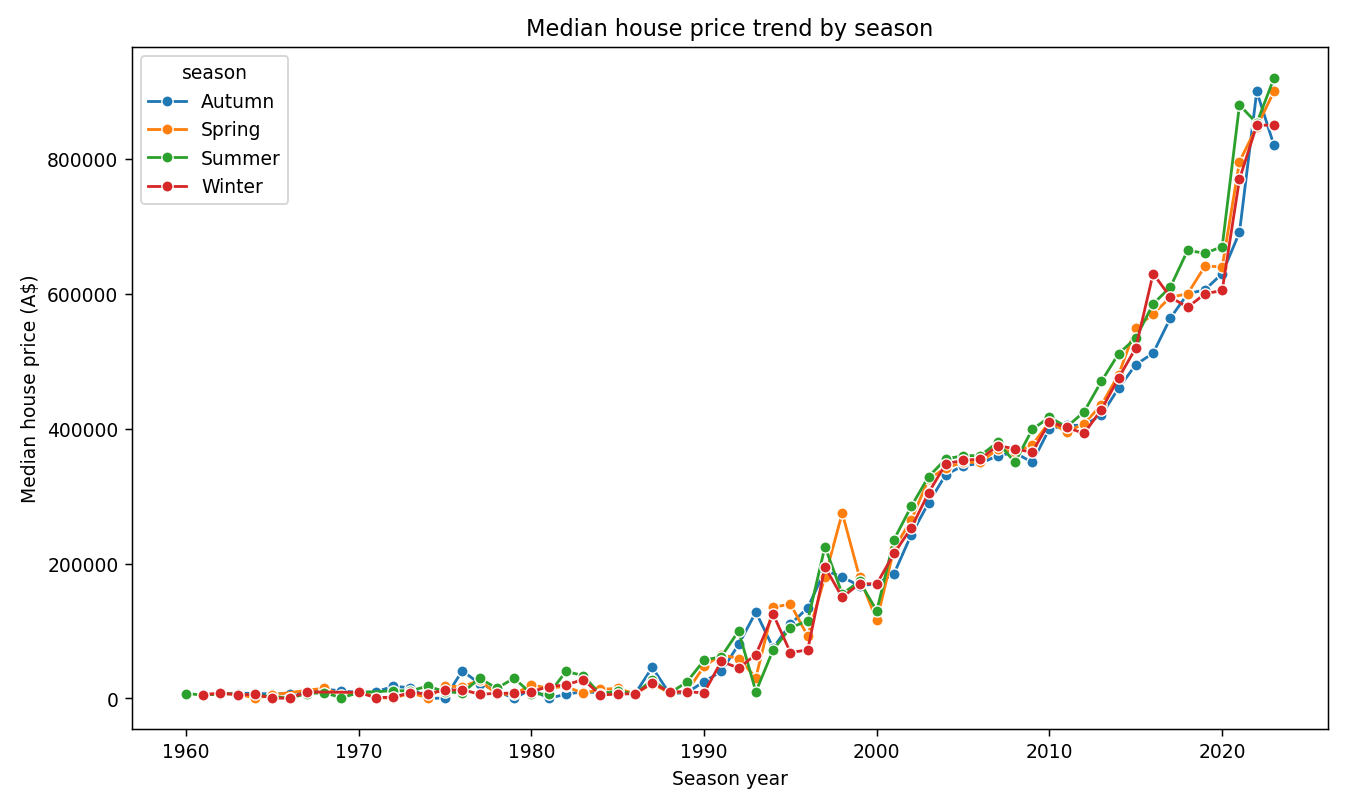

In [369]:
# Prepare the dataset containing for furthur use
sales_2 = (
    df_nsw_property_price
      .select(
          # Create sale_date: prefer settlement_date, if null then use contract_date
          F.coalesce(F.to_timestamp('iso_settlement_date'),
                     F.to_timestamp('iso_contract_date')).alias('sale_date'),
          # Cast purchase_price to double for numeric calculations
          F.col('purchase_price').cast('double').alias('purchase_price'),
          # Convert to lowercase as 'ptype' column 
          F.lower(F.col('property_type'))
      )
        # Keep only records with date, price not containing missing values
        # and property type = house
        .filter(
          F.col('sale_date').isNotNull() &
          F.col('purchase_price').isNotNull() &
          (F.col('property_type') == F.lit('house'))
      )
        # Extract year and month from sale_date
        .withColumn('year',  F.year('sale_date'))
        .withColumn('month', F.month('sale_date'))
        # Keep sales' values between 1960 and 2025
        .filter((F.col('year') > 1960) & (F.col('year') < 2025))
)

# Assign season and season_year
sales_season = ( sales_2
    .withColumn('month', F.month('sale_date'))
    .withColumn('season',
                F.when(F.col('month').isin(9,10,11), 'Spring')
                 .when(F.col('month').isin(12,1,2), 'Summer')
                 .when(F.col('month').isin(3,4,5), 'Autumn')
                 .otherwise('Winter')
    )
    # For Jan/Feb (month 1,2), shift year back by 1 to group Summer correctly
    .withColumn('season_year',
        F.when(F.col('month').isin(1,2), F.col('year') - 1)
         .otherwise(F.col('year'))
                
    # Repartition by season_year and season to optimize grouping
    ).repartition('season_year','season')
)

# Compute median house price per season per year
season_median = (
    sales_season.groupBy('season_year', 'season')
        .agg(F.expr('percentile_approx(purchase_price, 0.5, 100)').alias('median_price'))
        .orderBy('season_year', 'season')
)

# Display resilts
season_median.show()

# Convert to Pandas for plotting
pdf = season_median.toPandas()

# Define the order of seasons for consistent plotting
season_order = ['Autumn','Winter','Spring', 'Summer']   

# Ensure season column is categorical with defined order
pdf['season'] = pd.Categorical(pdf['season'], ordered=True)

# Set the figure size
plt.figure(figsize=(10,6))
# Draw a line plot of median house price per season-year
sns.lineplot(data=pdf, x='season_year', y='median_price',
             hue='season', marker='o')
# Label the x-axis
plt.xlabel('Season year')
# Label the y-axis
plt.ylabel('Median house price (A$)')
# Add title
plt.title('Median house price trend by season')
# Adjust layout to prevent overlap
plt.tight_layout()
# Display the plot
plt.show()

2.2.5 (Open Question) Explore the dataset freely and plot one diagram of your choice. Which columns (at least 2) are highly correlated to the sales price? Discuss the steps of your exploration and the results. (No word limit, please keep concise.) 

For the steps of exploration are as following:
<br> - Prepare the data by cleaning null values and unreasonable values
<br> - Check the statistical value to observe the distribution and outliers
<br> - Calculate log values of purchase_price and store in log_price to decrease the skewness.
<br> - Select the columns that are not cardinality or unique values.
<br> - Since various attributes are categorical, we cannot calculate correlationdirectly. Therefore, we calculate the eta-squared from one-way anova to compare the propotion of variance indicating how highly affect on the sales price.
<br> - Plot the bar chart of the eta-squared values to compare the effect on the sales price of each column. 
<br> Based on bar chart, features related to location, including 'suburb' (extracted from 'address' column), 'council' column, 'post-code' and 'zoning' are highly correlated to the sales price. This suggests that geographic and council-level factors can affect sales price.

<IPython.core.display.Javascript object>


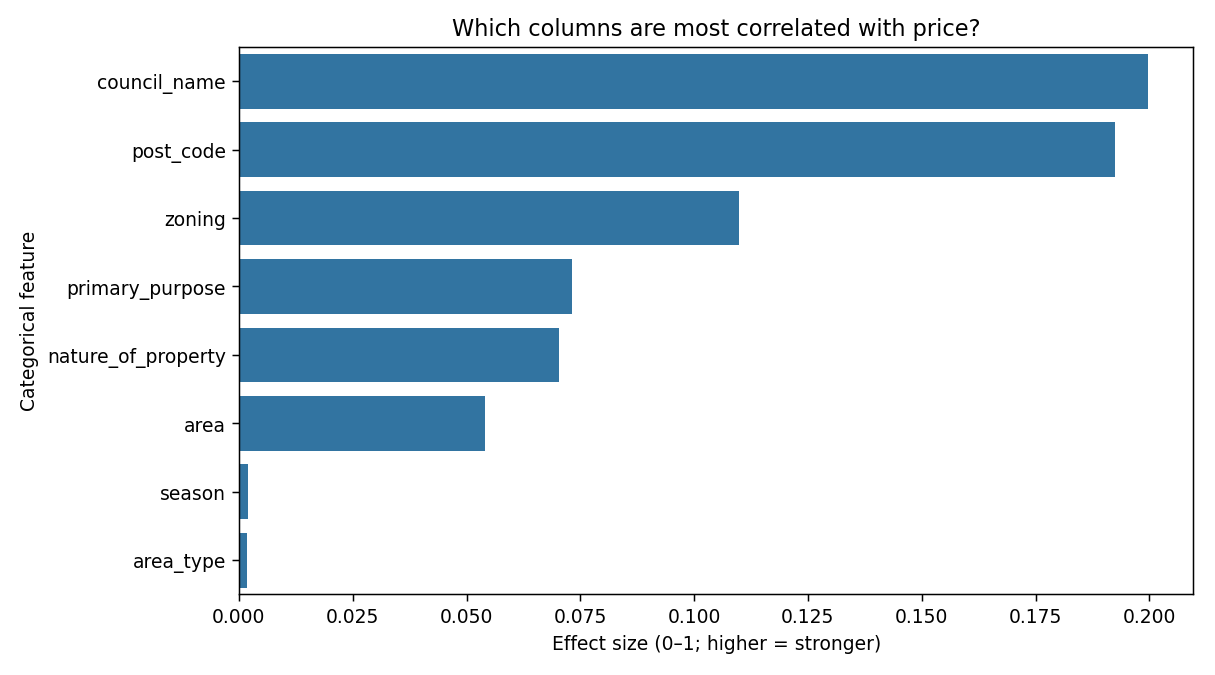

In [370]:
# Prepare the dataset containing for furthur use
#  Feature engineering on the base sales table
sales_3 = (
    df_nsw_property_price
        .select(
            # Create sale_date: prefer settlement_date, if null then use contract_date 
            F.coalesce(F.to_timestamp('iso_settlement_date'),
            F.to_timestamp('iso_contract_date')).alias('sale_date'),
            F.col('purchase_price').cast('double').alias('purchase_price'),
            'purpose_id',    # keep IDs for later joins
            'council_id',
            'zone_id'
        )
        # Log-transform price (reduce skew)
        .withColumn('log_price', F.log1p('purchase_price'))
        # Extract year and month from sale_date
        .withColumn('year',  F.year('sale_date'))
        .withColumn('month', F.month('sale_date'))
        # Create a season label from month
        .withColumn('season',
        F.when(F.col('month').isin(9,10,11),'Spring')
            .when(F.col('month').isin(12,1,2),'Summer')
            .when(F.col('month').isin(3,4,5),'Autumn')
            .otherwise('Winter'))
)

# Prepare small dimension tables for joining
pp = (df_property_purpose_updated
        .select('purpose_id', F.col('purpose_groups').alias('primary_purpose'))
        .alias('pp'))

c = (df_council
        .select('council_id', 'council_name') 
        .alias('c'))

z = (df_zoning
        .select(F.col('zoning_id').alias('zone_id'),
                'zoning')    
        .alias('z'))

# Join table to contian purpose_id, council_id, zone_id 
# to using the primary_purpose, council_name, zoning
sales_enriched = (
        sales_3.join(pp, on='purpose_id', how='left')
            .join(c, on='council_id', how='left')
            .join(z, on='zone_id',    how='left'))

# Define candidate categorical columns to test
candidates = ['suburb','post_code','pc3','council_name','zoning','primary_purpose',
              'area_type','nature_of_property','season','area'] 

# Only keep candidate columns that exist in the DataFrame
cats = [c for c in candidates if c in sales2.columns]

# Define function to calculate  
def anova_eta2_cal(df, y, cat, min_n):
    
    # Calculate stats for eta calculation
    tot = (df.select(
        # total number of rows
        F.count('*').alias('n'), 
        # overall mean
        F.avg(y).alias('avg'), 
        # population variance
        F.var_pop(y).alias('var')).first())
    
    n, avg = int(tot['n']), float(tot['avg'])
    
    # Return zeros if the dataset is empty
    if n == 0:
        return {'cat': cat, 'eta2': 0.0, 'F': None, 'groups': 0}
    
    # Group stats per category value 
    by = (df.groupBy(cat)
              # number of rows in the group
            .agg(F.count('*').alias('n_grp'),
                # group mean
                F.avg(y).alias('avg_grp'),
                # group variance
                F.var_pop(y).alias('var_grp'))
              # Filter out very small groups to avoid unstable results
            .filter(F.col('n_grp') >= min_n))
    
    # Aggregate sums of squares 
    a = by.select(
        # Between-group sum of squares: sum(n_g * (mean_g - overall_mean)^2)
        F.sum(F.col('n_grp') * (F.col('avg_grp') - F.lit(avg))**2).alias('SSb'),
        # Within-group sum of squares: sum(n_g * var_g)
        F.sum(F.col('n_grp') * F.col('var_grp')).alias('SSw'), 
        # Number of groups considered
        F.count('*').alias('g')
    ).first()
    
    
    SSb = float(a['SSb'] or 0.0)
    SSw = float(a['SSw'] or 0.0)
    g   = int(a['g'] or 0)
    
    # If only one group remains, or invalid variance, return zero
    if g <= 1 or SSw <= 0 or n - g <= 0:
        return {'cat': cat, 'eta2': 0.0, 'F': None, 'groups': g}

    # Calculate eta-squared (effect size)
    eta2   = SSb / (SSb + SSw)                              

    return {'cat': cat, 'eta2': float(eta2), 'groups': g}

# Apply the function to all candidate categorical columns
scores = [anova_eta2_cal(sales2, y='log_price', cat=c, min_n=50) for c in cats]
# Convert results to Pandas DataFrame and sort by effect size
score_df = pd.DataFrame(scores).sort_values('eta2', ascending=False)

# Set the figure size
fig, ax = plt.subplots(figsize=(9,5))
# Plot categorical feature vs eta2 (effect size)
sns.barplot(data=score_df, x='eta2', y='cat', ax=ax)
# Add labels and title
ax.set_xlabel('Effect size (0–1; higher = stronger)')
ax.set_ylabel('Categorical feature')
ax.set_title('Which columns are most correlated with price?')
# Adjust layout for better appearance
plt.tight_layout()
plt.show()   

### Part 3 RDDs vs DataFrame vs Spark SQL (25%) <a class="anchor" name="part-3"></a>
Implement the following complex queries using RDD, DataFrame in SparkSQL separately(choose two). Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 2 approaches of your choice.
(notes: You can write a multi-step query or a single complex query, the choice is yours. You can reuse the data frame in Part 2.)

#### Complex Query:
<pre>
A property investor wants to understand whether the property price and the settlement date are correlated. Here is the conditions:
1)	The investor is only interested in the last 2 years of the dataset.
2)	The investor is looking at houses under $2 million.
3)	Perform a bucketing of the settlement date (settlement – contract date
range (15, 30, 45, 60, 90 days).
4)	Perform a bucketing of property prices in $500K(e.g. 0-$500K, $500K-$1M, $1M-$1.5M, $1.5-$2M)
5)	Count the number of transactions in each combination and print the result in the following format
(Note: It’s fine to count the same property multiple times in this task, it’s based on sales transactions).
(Note: You shall show the full table with 40 rows, 2 years *4 price bucket * 5 settlement bucket; 0 count should be displayed as 0, not omitted.)
</pre>

### a)	Implement the above query using two approaches of your choice separately and print the results. (Note: Outputs from both approaches of your choice are required, and the results should be the same.). 

#### 3.1. Implementation 1

In [371]:
%%time

df_nsw_property_price_p3_1 = (
    df_nsw_property_price
    # Convert purchase_price to numeric (double)
    .withColumn('purchase_price', F.col('purchase_price').cast('double'))
    # Ensure contract and settlement dates are in proper date format
    .withColumn('iso_contract_date', F.to_date('iso_contract_date'))
    .withColumn('iso_settlement_date', F.to_date('iso_settlement_date'))
     # Keep only rows with both dates present
    .filter(F.col('iso_settlement_date').isNotNull())
    .filter(F.col('iso_contract_date').isNotNull())
    # Settlement date must be after or equal to contract date
    .filter(F.col('iso_settlement_date') >= F.col('iso_contract_date'))
    # Remove future-dated records
    .filter(F.col('iso_settlement_date') <= F.current_date())
    # Remove very old records (before 1990)
    .filter(F.col('iso_settlement_date') >= F.lit('1990-01-01').cast('date'))
)

# Find the maximum year present in the settlement_date column
max_year = (df_nsw_property_price_p3_1.select(F.max(F.year('iso_settlement_date')).alias('y'))
           .collect()[0]['y'])

# Build a list containing the last two years
years_keep = [max_year-1, max_year]

# Filter the dataset to include only rows that 
# settlement_date is not null
# 2) year(settlement_date) is either the latest year or the year before it
df_nsw_property_price_twoyear = (df_nsw_property_price_p3_1
                                 .filter(F.col('iso_settlement_date').isNotNull())
                                 .filter(F.year('iso_settlement_date').isin(years_keep))
)

# Keep only 'house' that are between 0 and 2 million
house_two_mill = (
    df_nsw_property_price_twoyear
    .filter(F.lower(F.col('property_type')) == 'house')
    .filter(F.col('purchase_price') >= 0)
    .filter(F.col('purchase_price') < 2_000_000)
)


# Number of days from contract to settlement
date_range = F.datediff(F.col('iso_settlement_date'), F.col('iso_contract_date'))

# Keep only settlements completed within 0–90 days
house_range = (house_two_mill
    .withColumn('settle_days', date_range)
    .filter((F.col('settle_days') >= 0) & (F.col('settle_days') <= 90))
)

# Define bucketing rules
# Settlement bucket: 0–15, 16–30, 31–45, 46–60, 61–90
settle_bucket = (F.when(F.col('settle_days') <= 15,  '0-15')
                   .when(F.col('settle_days') <= 30, '16-30')
                   .when(F.col('settle_days') <= 45, '31-45')
                   .when(F.col('settle_days') <= 60, '46-60')
                   .otherwise('61-90'))
# Price bucket: four ranges from 0–2M
price_bucket = (F.when(F.col('purchase_price') < 500_000, '$0-$500k')
                  .when(F.col('purchase_price') < 1_000_000,'$500k-$1M')
                  .when(F.col('purchase_price') < 1_500_000,'$1M-$1.5M')
                  .otherwise('$1.5M-$2M'))

# reduced to only the fields required for aggregation
fact = (house_range
    .withColumn('year', F.year('iso_settlement_date'))
    .withColumn('settle_bucket', settle_bucket)
    .withColumn('price_bucket',  price_bucket)
    .select('year','settle_bucket','price_bucket')
)

# Build complete dimensional grid (year × settle × price)
# Year dimension 
dim_year   = spark.createDataFrame([(y,) for y in years_keep], ['year'])
# Settlement day bucket dimension
dim_settle = spark.createDataFrame(
    [('0-15',), ('16-30',), ('31-45',), ('46-60',), ('61-90',)],
    ['settle_bucket']
)
# Price bucket dimension
dim_price  = spark.createDataFrame(
    [('$0-$500k',), ('$500k-$1M',), ('$1M-$1.5M',), ('$1.5M-$2M',)],
    ['price_bucket']
)

# Full cube of all dimension combinations
full_grid = dim_year.crossJoin(dim_settle).crossJoin(dim_price)

# Count number of records per 
counts = fact.groupBy('year','settle_bucket','price_bucket').count()

# Left join ensures all dimension cells exist
# Fill missing with zero
result = (full_grid
    .join(F.broadcast(counts), ['year','settle_bucket','price_bucket'], 'left')
    .fillna({'count': 0})
)

# Show results
result.show(40, truncate=False)


+----+-------------+------------+-----+
|year|settle_bucket|price_bucket|count|
+----+-------------+------------+-----+
|2023|0-15         |$0-$500k    |3123 |
|2023|0-15         |$500k-$1M   |2399 |
|2023|0-15         |$1M-$1.5M   |700  |
|2023|0-15         |$1.5M-$2M   |315  |
|2023|16-30        |$0-$500k    |5632 |
|2023|16-30        |$500k-$1M   |8556 |
|2023|16-30        |$1M-$1.5M   |2513 |
|2023|16-30        |$1.5M-$2M   |923  |
|2023|31-45        |$0-$500k    |6416 |
|2023|31-45        |$500k-$1M   |17969|
|2023|31-45        |$1M-$1.5M   |8316 |
|2023|31-45        |$1.5M-$2M   |3866 |
|2023|46-60        |$0-$500k    |1387 |
|2023|61-90        |$0-$500k    |1189 |
|2023|46-60        |$500k-$1M   |4984 |
|2023|61-90        |$500k-$1M   |3859 |
|2023|46-60        |$1M-$1.5M   |3505 |
|2023|61-90        |$1M-$1.5M   |3429 |
|2023|46-60        |$1.5M-$2M   |1867 |
|2023|61-90        |$1.5M-$2M   |2194 |
|2024|0-15         |$0-$500k    |251  |
|2024|0-15         |$500k-$1M   |235  |


#### 3.2. Implementation 2

In [373]:
%%time

df_nsw_property_price.createOrReplaceTempView('sales')

result = spark.sql("""
    -- Normalize and prepare raw columns for later use
    WITH main_table AS (
    SELECT
        -- Convert purchase_price to numeric (double type)
        CAST(purchase_price AS double) AS price,
        -- Convert property_type lowercase 
        lower(property_type) AS ptype,
        -- Convert date string to date type
        to_date(iso_contract_date,  'yyyy-MM-dd') AS contract_date,
        to_date(iso_settlement_date,'yyyy-MM-dd') AS settle_date
      FROM sales
),
    
    -- Filter out records with invalid or unreasonable dates
    filtered AS (
        SELECT *
        FROM main_table 
        -- Exclude rows where is missing
        WHERE settle_date IS NOT NULL
            AND contract_date IS NOT NULL
        -- Settlement cannot occur before contract
            AND settle_date >= contract_date
            AND settle_date <= current_date()
    ),
    
    -- Get the latest year in the dataset 
    yr AS (
        SELECT LEAST(max(year(settle_date)), year(current_date())) AS max_year 
        FROM filtered
    ),
    -- Restrict data to only the last two years
    last_two_year AS (
        SELECT f.*
        FROM filtered f, yr
        WHERE year(f.settle_date) IN (yr.max_year-1, yr.max_year)
    ),
    
    -- Keep only houses having price between 0 to 2 million 
    -- and having gap of settlement date in the settlement date
    filter_HOUSE AS (
        SELECT *
        FROM last_two_year
        WHERE ptype = 'house'
            AND price >= 0 AND price < 2000000
            AND datediff(settle_date, contract_date) BETWEEN 0 AND 90
    ),
    
    -- Transform into analytical buckets (year, settlement period, price range)
    fact AS (
        SELECT year(settle_date) AS year_settle,
        -- Create bucket for settlement day range
            CASE 
                WHEN datediff(settle_date, contract_date) <= 15 THEN '0-15'
                WHEN datediff(settle_date, contract_date) <= 30 THEN '16-30'
                WHEN datediff(settle_date, contract_date) <= 45 THEN '31-45'
                WHEN datediff(settle_date, contract_date) <= 60 THEN '46-60'
                ELSE '61-90'
            END AS settle_bucket,
            -- Create price buckets
            CASE
                WHEN price < 500000 THEN '$0-$500k'
                WHEN price < 1000000 THEN '$500k-$1M'
                WHEN price < 1500000 THEN '$1M-$1.5M'
                ELSE '$1.5M-$2M'
            END AS price_bucket
        FROM filter_HOUSE
    ),
    
    -- Create year dimension table
    dim_year AS (
        SELECT v.y AS year_for_dim
        FROM yr
         -- Inline array to generate rows for last 2 years
        LATERAL VIEW inline(array(
            struct(yr.max_year-1 AS y),
            struct(yr.max_year   AS y)
      )) v
),
    -- Create dimension table of settlement buckets
    dim_settle AS (
        SELECT stack(5, '0-15', '16-30', '31-45', '46-60', '61-90') AS settle_bucket        
    ),
    -- Create dimension table of price buckets
    dim_price AS (
        SELECT stack(4, '$0-$500k', '$500k-$1M', '$1M-$1.5M', '$1.5M-$2M') AS price_bucket
    ),
    
    -- Build full grid of all combinations of year, settlement bucket, price bucket
    grid AS (
        SELECT * FROM dim_year CROSS JOIN dim_settle CROSS JOIN dim_price
    ),
    -- Aggregate the fact table into counts per combination
    agg AS (
        SELECT year_settle, settle_bucket, price_bucket, COUNT(*) AS count
        FROM fact
        GROUP BY year_settle, settle_bucket, price_bucket
    )
    
     -- Join the grid with aggregated counts 
     -- fill missing combinations with 0 
    SELECT /*+ BROADCAST(a) */
        g.year_for_dim AS Year, 
        g.settle_bucket AS `Price Range`, 
        g.price_bucket AS `Price Range`, 
        -- Replace NULL counts with 0 for missing grid combinations
        COALESCE(a.count, 0) AS Count
    FROM grid g
    LEFT JOIN agg a
        ON g.year_for_dim  = a.year_settle  
        AND g.settle_bucket = a.settle_bucket
        AND g.price_bucket=a.price_bucket
    -- Order results by year
    ORDER BY g.year_for_dim,
    -- Enforce sort order for settlement and price bucket
        CASE g.settle_bucket WHEN '0-15' THEN 1 WHEN '16-30' THEN 2 WHEN '31-45' THEN 3 WHEN '46-60' THEN 4 ELSE 5 END,
        CASE g.price_bucket WHEN '$0-$500k' THEN 1 WHEN '$500k-$1M' THEN 2 WHEN '$1M-$1.5M' THEN 3 ELSE 4 END
""")

result.show(40, truncate=False) 

+----+-----------+-----------+-----+
|Year|Price Range|Price Range|Count|
+----+-----------+-----------+-----+
|2023|0-15       |$0-$500k   |3123 |
|2023|0-15       |$500k-$1M  |2399 |
|2023|0-15       |$1M-$1.5M  |700  |
|2023|0-15       |$1.5M-$2M  |315  |
|2023|16-30      |$0-$500k   |5632 |
|2023|16-30      |$500k-$1M  |8556 |
|2023|16-30      |$1M-$1.5M  |2513 |
|2023|16-30      |$1.5M-$2M  |923  |
|2023|31-45      |$0-$500k   |6416 |
|2023|31-45      |$500k-$1M  |17969|
|2023|31-45      |$1M-$1.5M  |8316 |
|2023|31-45      |$1.5M-$2M  |3866 |
|2023|46-60      |$0-$500k   |1387 |
|2023|46-60      |$500k-$1M  |4984 |
|2023|46-60      |$1M-$1.5M  |3505 |
|2023|46-60      |$1.5M-$2M  |1867 |
|2023|61-90      |$0-$500k   |1189 |
|2023|61-90      |$500k-$1M  |3859 |
|2023|61-90      |$1M-$1.5M  |3429 |
|2023|61-90      |$1.5M-$2M  |2194 |
|2024|0-15       |$0-$500k   |251  |
|2024|0-15       |$500k-$1M  |235  |
|2024|0-15       |$1M-$1.5M  |73   |
|2024|0-15       |$1.5M-$2M  |25   |
|

### b)	Which one is easier to implement, in your opinion? Log the time taken for each query, and observe the query execution time, among DataFrame and SparkSQL, which is faster and why? Please include proper references. (Maximum 500 words.) 

After process the query of both implements, I found that SparkSQL is easier for me to write as i familiar with 'SQL' code more than 'Spark Pyhton' commands. The DataFrame API is new for me. I feel it a bit complex and longer the 'SparkSQL'.
<br>
For speed, my logging time test shows that the DataFrame pipeline finished in  19.2 seconds, while the SparkSQL query finished in 25.2 seconds. 
<br>
Although, SparkSQL is easier to write for me. The DataFrame API is better since it can run quicker than SparkSQL. I might because of using an extra ORDER BY in SQL to sort output. Sorting across a cluster is expensive and explains the extra seconds (Erkec, 2021). While the Dataframe was looked sorted without global sort commands because the small dimension tables kept their original order and the broadcast join preserved that order. That make wider shuffle. Moreover, 'settle_day' was called many times in SparkSQL, more than DataFrame.

Erkec, E. (2021, January 5). SQL Server ORDER BY performance tips. SQL Shack. Retrieved from https://www.sqlshack.com/sql-server-order-by-performance-tips/

### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html